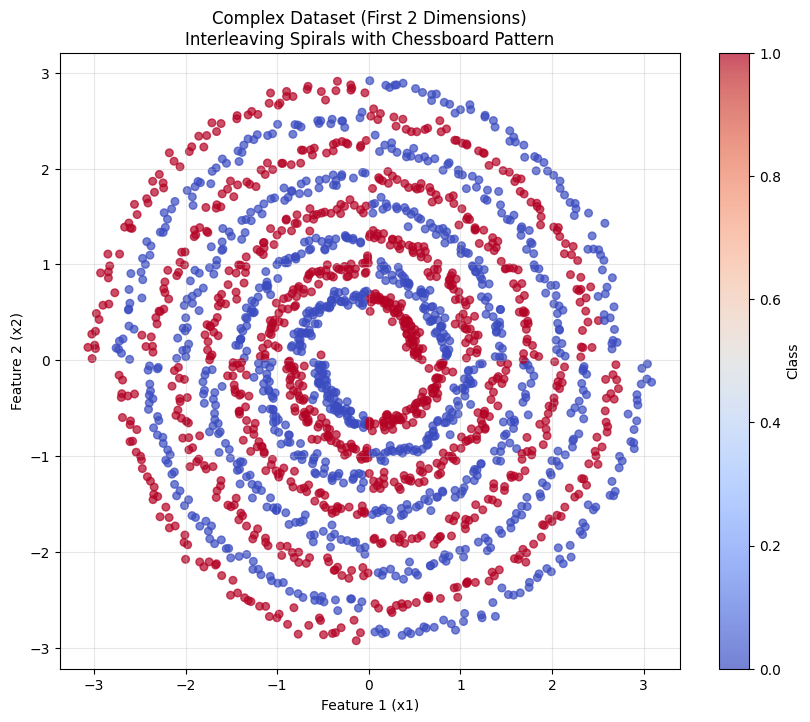

Dataset shape: (2000, 5)
Number of features: 5
Class distribution: [ 985 1015]

Training set shape (transposed): (5, 1600)
Test set shape (transposed): (5, 400)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def make_complex_decision_boundary(n_samples=1000, noise=0.1):
    """
    Creates a complex dataset with multiple decision regions
    that can achieve 100% accuracy with proper architecture
    """
    np.random.seed(42)
    
    # Create two interleaving spirals
    n = n_samples // 2
    theta = np.linspace(0, 8 * np.pi, n)
    
    # Spiral 1 (Class 0)
    r1 = theta * 0.1 + 0.5
    X1 = np.c_[r1 * np.cos(theta) + noise * np.random.randn(n),
               r1 * np.sin(theta) + noise * np.random.randn(n)]
    
    # Spiral 2 (Class 1) - rotated and slightly different
    r2 = theta * 0.1 + 0.5
    X2 = np.c_[r2 * np.cos(theta + np.pi) + noise * np.random.randn(n),
               r2 * np.sin(theta + np.pi) + noise * np.random.randn(n)]
    
    # Add some polynomial features to make it more complex
    X1 = np.hstack([X1, X1[:, 0:1]**2, X1[:, 1:2]**2, X1[:, 0:1] * X1[:, 1:2]])
    X2 = np.hstack([X2, X2[:, 0:1]**2, X2[:, 1:2]**2, X2[:, 0:1] * X2[:, 1:2]])
    
    X = np.vstack([X1, X2])
    y = np.hstack([np.zeros(n), np.ones(n)])
    
    # Add more complexity: chessboard pattern in first two dimensions
    for i in range(X.shape[0]):
        if ((X[i, 0] > 0 and X[i, 1] > 0) or (X[i, 0] < 0 and X[i, 1] < 0)):
            y[i] = 1 - y[i]  # Flip label for additional complexity
    
    return X, y.reshape(-1, 1)

# Generate the complex dataset
X, y = make_complex_decision_boundary(n_samples=2000, noise=0.05)

# Visualize the first two dimensions
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm', s=30, alpha=0.7)
plt.xlabel('Feature 1 (x1)')
plt.ylabel('Feature 2 (x2)')
plt.title('Complex Dataset (First 2 Dimensions)\nInterleaving Spirals with Chessboard Pattern')
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution: {np.bincount(y.flatten().astype(int))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for better NN performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transpose for neural network
X_train_t = X_train.T
X_test_t = X_test.T
y_train_t = y_train.T
y_test_t = y_test.T

print(f"\nTraining set shape (transposed): {X_train_t.shape}")
print(f"Test set shape (transposed): {X_test_t.shape}")

In [14]:
def initialize_parameters(n_x, n_h, n_y):

    parameters = {}
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters['W1'] = W1
    parameters['b1']  = b1
    parameters['W2'] = W2
    parameters['b2'] = b2
    return parameters
    

In [15]:
def activation(Z, act):

    if act =='relu':
        return np.maximum(Z, 0)
    if act =='sigmoid':
        return 1/(1+np.exp(-Z))

In [16]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = activation(Z1, 'relu')

    Z2 = np.dot(W2, A1)  + b2
    A2 = activation(Z2, 'sigmoid')

    cache ={"Z1":Z1, "A1":A1, "Z2":Z2, "A2":A2}
    return A2, cache

In [24]:
def compute_cost(A2, Y):
    m = Y.shape[1]
    cost = -np.sum(Y*np.log(A2 + 1e-8) + (1-Y)*np.log(1-A2+1e-8))/m
    return cost
    

In [25]:
def relu_derivatives(Z):
    return (Z > 0).astype(float)

In [26]:
def backward_propagation(parameters, cache, Y, X):
    m = X.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']

    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    Z2 = cache['Z2']

    dZ2 = A2- Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = np.dot(W2.T, dZ2)*relu_derivatives(Z1)
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)

    grads= {}
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW1'] = dW1
    grads['db1'] = db1

    return grads

In [27]:
def update_parameters(grads, learning_rate , parameters):
    parameters['W1'] = parameters['W1'] - learning_rate * grads['dW1']
    parameters['W2'] = parameters['W2'] - learning_rate * grads['dW2']
    parameters['b1'] = parameters['b1'] - learning_rate * grads['db1']
    parameters['b2'] = parameters['b2'] - learning_rate * grads['db2']
    return parameters
     
    

In [36]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost =False):
    n_x = X.shape[0]
    n_y = Y.shape[0]
    n_h = n_h
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(num_iterations):

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        if print_cost and i%1000 ==0:
            print(f"the cost after {i}: {cost}")
        grads = backward_propagation(parameters, cache, Y, X)
        parameters = update_parameters(grads, 0.01, parameters)
    return parameters

In [37]:
def predict(parameters, X):
    A2, _= forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)
    return predictions
    

In [38]:
parameters = nn_model(X_train_t, y_train_t, 20, 10000, True)

the cost after 0: 0.6931531223162828
the cost after 1000: 0.6930140910213399
the cost after 2000: 0.6929512279639951
the cost after 3000: 0.6928289808756257
the cost after 4000: 0.6925807109918023
the cost after 5000: 0.6920805337939007
the cost after 6000: 0.6911835092367764
the cost after 7000: 0.6898675245975835
the cost after 8000: 0.6884611214665002
the cost after 9000: 0.6874076798500561


In [39]:
predictions = predict(parameters, X_test_t)

In [40]:
print(np.mean(predictions ==y_test_t)*100)

52.75
